# Brain Tumor Classification

## Clone the Github Repo to access the Dataset

In [57]:
!git clone https://github.com/Ashish-Arya-CS/Coursera-Content.git

fatal: destination path 'Coursera-Content' already exists and is not an empty directory.


## Import necessary Libraries 

In [58]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [59]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import imutils    


## Creating Directories to store Cropped Images

In [60]:
# Create Directory for Training Data

!mkdir Crop-Brain-MRI
!mkdir Crop-Brain-MRI/glima_tumor
!mkdir Crop-Brain-MRI/meningioma_tumor
!mkdir Crop-Brain-MRI/no_tumor
!mkdir Crop-Brain-MRI/pituitary_tumor

mkdir: cannot create directory ‘Crop-Brain-MRI’: File exists
mkdir: cannot create directory ‘Crop-Brain-MRI/glima_tumor’: File exists
mkdir: cannot create directory ‘Crop-Brain-MRI/meningioma_tumor’: File exists
mkdir: cannot create directory ‘Crop-Brain-MRI/no_tumor’: File exists
mkdir: cannot create directory ‘Crop-Brain-MRI/pituitary_tumor’: File exists


In [61]:
# Create Directory for Testing Data
!mkdir Test-data
!mkdir Test-data/glima_tumor
!mkdir Test-data/meningioma_tumor
!mkdir Test-data/no_tumor
!mkdir Test-data/pituitary_tumor

mkdir: cannot create directory ‘Test-data’: File exists
mkdir: cannot create directory ‘Test-data/glima_tumor’: File exists
mkdir: cannot create directory ‘Test-data/meningioma_tumor’: File exists
mkdir: cannot create directory ‘Test-data/no_tumor’: File exists
mkdir: cannot create directory ‘Test-data/pituitary_tumor’: File exists


## Data Visualization

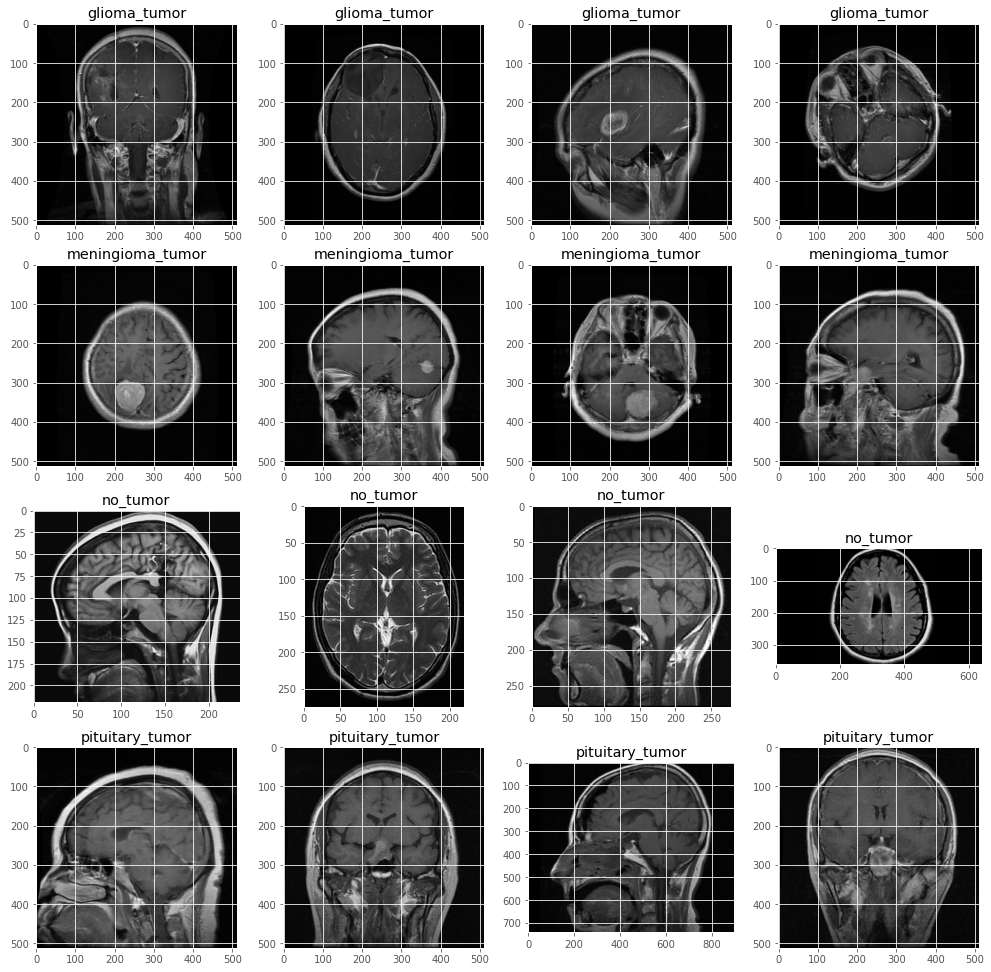

In [62]:
train_dir = "/content/Coursera-Content/Brain-MRI/Training/"
test_dir = "/content/Coursera-Content/Brain-MRI/Testing/"
classes = os.listdir("/content/Coursera-Content/Brain-MRI/Training")
files_path_dict = {}

for c in classes:
  files_path_dict[c] = list(map(lambda x: train_dir+c+'/'+x, os.listdir(train_dir+c)))

plt.figure(figsize=(17, 17))
index = 0

for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:5]

  for i in range(1, 5):
    index += 1
    plt.subplot(4, 4, index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)

## Create a Function to Crop Images

In [63]:
# removing black surroundings
def crop_image(image, plot=False):
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)
    
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]
    img_thresh = cv2.erode(img_thresh, None, iterations=2)
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]            

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image


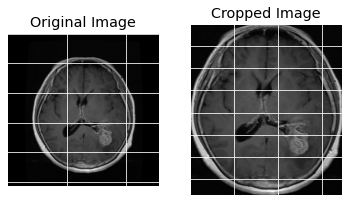

array([[[5, 5, 5],
        [5, 5, 5],
        [5, 5, 5],
        ...,
        [6, 6, 6],
        [6, 6, 6],
        [6, 6, 6]],

       [[5, 5, 5],
        [5, 5, 5],
        [5, 5, 5],
        ...,
        [6, 6, 6],
        [6, 6, 6],
        [6, 6, 6]],

       [[5, 5, 5],
        [5, 5, 5],
        [5, 5, 5],
        ...,
        [6, 6, 6],
        [6, 6, 6],
        [6, 6, 6]],

       ...,

       [[4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [4, 4, 4],
        [4, 4, 4],
        [4, 4, 4]],

       [[4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [4, 4, 4],
        [4, 4, 4],
        [4, 4, 4]],

       [[4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [4, 4, 4],
        [4, 4, 4],
        [4, 4, 4]]], dtype=uint8)

In [64]:
example_img = cv2.imread("/content/Coursera-Content/Brain-MRI/Training/glioma_tumor/gg (10).jpg")
cropped_image = crop_image(example_img, plot = True)
cropped_image

## Saving The Cropped Images 

In [65]:
# Crop the Training Images and Save it to the Directory we previously cretaed
glioma = train_dir + "glioma_tumor"
meningioma = train_dir + "meningioma_tumor"
no_tumor = train_dir + "no_tumor"
pituitary = train_dir + "pituitary_tumor"

j = 0
for i in tqdm(os.listdir(glioma)):
  path = os.path.join(glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Crop-Brain-MRI/glima_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(meningioma)):
  path = os.path.join(meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Crop-Brain-MRI/meningioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(no_tumor)):
  path = os.path.join(no_tumor, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Crop-Brain-MRI/no_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(pituitary)):
  path = os.path.join(pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Crop-Brain-MRI/pituitary_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1


100%|██████████| 901/901 [00:06<00:00, 143.88it/s]


In [66]:
# Crop the Testing Images and Save it to the Directory we previously cretaed
test_glioma = test_dir + "glioma_tumor"
test_meningioma = test_dir + "meningioma_tumor"
test_no_tumor = test_dir + "no_tumor"
test_pituitary = test_dir + "pituitary_tumor"

j = 0
for i in tqdm(os.listdir(test_glioma)):
  path = os.path.join(test_glioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Test-data/glima_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(test_meningioma)):
  path = os.path.join(test_meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Test-data/meningioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(test_meningioma)):
  path = os.path.join(test_meningioma, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Test-data/no_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

j = 0
for i in tqdm(os.listdir(test_pituitary)):
  path = os.path.join(test_pituitary, i)
  img = cv2.imread(path)
  img = crop_image(img, plot=False)
  if img is not None:
    img = cv2.resize(img, (224, 224))
    save_path = "/content/Test-data/pituitary_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path, img)
    j = j+1

100%|██████████| 5/5 [00:00<00:00, 109.80it/s]


## Perform Data Augmentation and Prepare the Train, Validation and Test Dataset

In [67]:
# Use Image Data Generator to perform this task.
datagen = ImageDataGenerator(rotation_range=10, height_shift_range=0.2, horizontal_flip=True, validation_split=0.2)
train_data = datagen.flow_from_directory("/content/Crop-Brain-MRI/", 
                                         target_size=(224, 224),
                                         batch_size = 32,
                                         class_mode = 'categorical',
                                         subset = 'training')

valid_data = datagen.flow_from_directory("/content/Crop-Brain-MRI/", 
                                         target_size=(224, 224),
                                         batch_size = 32,
                                         class_mode = 'categorical',
                                         subset = 'validation')

test_datagen =  ImageDataGenerator()
test_data = datagen.flow_from_directory('/content/Test-data/',
                                         target_size = (224, 224),
                                         class_mode = 'categorical'
                                         )


Found 2613 images belonging to 4 classes.
Found 652 images belonging to 4 classes.
Found 20 images belonging to 4 classes.


In [68]:
# View the class dictionary
print(train_data.class_indices)
print(test_data.class_indices)

{'glima_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{'glima_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


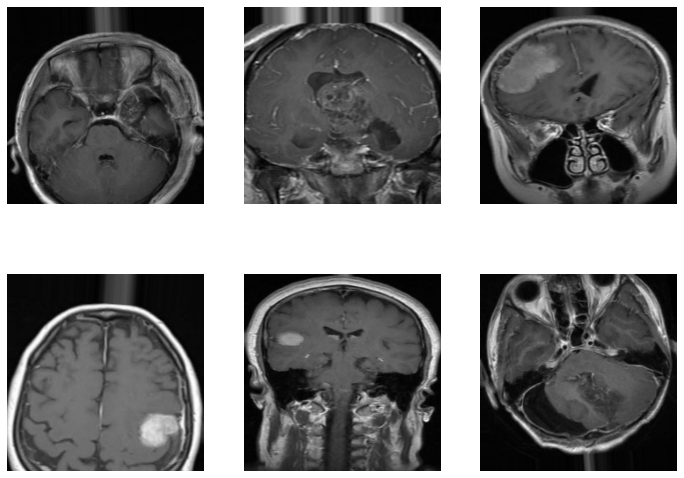

In [69]:
# View the augmented data.
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12, 9))

for i in range(6):
  plt.subplot(2, 3, i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show()


## Build and Compile the Model 

In [70]:
# Build the Model
effnet = EfficientNetB1(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4, activation='softmax')(model)
model = Model(inputs = effnet.input, outputs = model)

model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_2 (Rescaling)         (None, 224, 224, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
normalization_2 (Normalization) (None, 224, 224, 3)  7           rescaling_2[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization_2[0][0]            
____________________________________________________________________________________________

In [71]:
!pip3 install keras --upgrade

In [72]:
model.compile(optimizer=Adam(learning_rate = 0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])
checkpoint = ModelCheckpoint("model.h5", monitor='val_accuracy', save_best_only=True, mode = 'auto', verbose =1)

earlystop = EarlyStopping(monitor='val_accuracy', patience=5, mode='auto', verbose=1)

## Model Training and Model Evaluation

In [73]:
# Train the model
history = model.fit(train_data, epochs=7, validation_data=valid_data, verbose = 1, callbacks=[checkpoint, earlystop])

Epoch 1/7
82/82 [==============================] - 91s 942ms/step - loss: 0.8578 - accuracy: 0.6594 - val_loss: 0.8245 - val_accuracy: 0.6549

Epoch 00001: val_accuracy improved from -inf to 0.65491, saving model to model.h5


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/7
82/82 [==============================] - 74s 903ms/step - loss: 0.3785 - accuracy: 0.8691 - val_loss: 0.6104 - val_accuracy: 0.7454

Epoch 00002: val_accuracy improved from 0.65491 to 0.74540, saving model to model.h5
Epoch 3/7
82/82 [==============================] - 74s 900ms/step - loss: 0.2343 - accuracy: 0.9254 - val_loss: 0.4017 - val_accuracy: 0.8497

Epoch 00003: val_accuracy improved from 0.74540 to 0.84969, saving model to model.h5
Epoch 4/7
82/82 [==============================] - 75s 910ms/step - loss: 0.1475 - accuracy: 0.9575 - val_loss: 0.4276 - val_accuracy: 0.8359

Epoch 00004: val_accuracy did not improve from 0.84969
Epoch 5/7
82/82 [==============================] - 75s 911ms/step - loss: 0.1061 - accuracy: 0.9675 - val_loss: 0.2920 - val_accuracy: 0.8850

Epoch 00005: val_accuracy improved from 0.84969 to 0.88497, saving model to model.h5
Epoch 6/7
82/82 [==============================] - 74s 901ms/step - loss: 0.0828 - accuracy: 0.9755 - val_loss: 0.2286

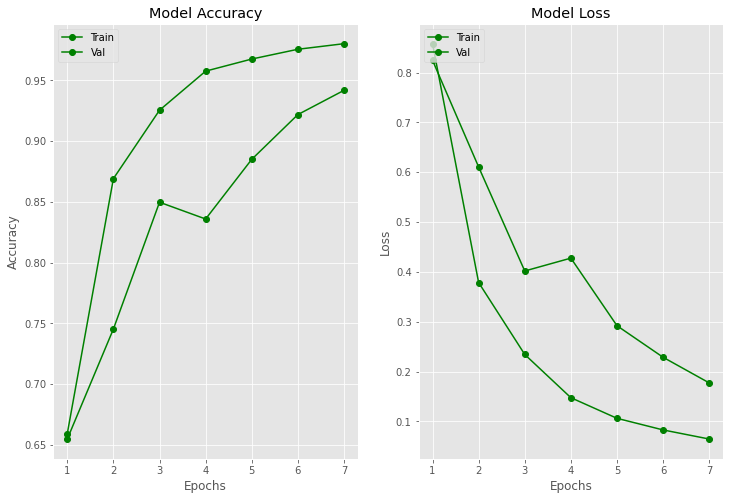

In [74]:
# Plot the training curves
plt.style.use("ggplot")
plt.figure(figsize=(12, 8))
epochs = range(1, 8)
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], "go-")
plt.plot(epochs, history.history['val_accuracy'], "go-")
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel("Accuracy")
plt.legend(["Train", "Val"], loc = 'upper left')


plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], "go-")
plt.plot(epochs, history.history['val_loss'], "go-")
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.legend(["Train", "Val"], loc = 'upper left')
plt.show()

In [75]:
# Evaluate the model on Test Set
model.evaluate(test_data)

1/1 [==============================] - 0s 362ms/step - loss: 2.1284 - accuracy: 0.7000


[2.128420352935791, 0.699999988079071]

## Obtaining Predictions on Test Images

meningioma_tumor


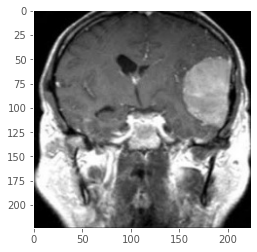

In [86]:
# Obtain Predictions on Test Images
class_dict = {0: 'glioma_tumor', 1: 'meningioma_tumor', 2: 'no_tumor', 3:'pituitary_tumor'}

test_img1 = cv2.imread("/content/Test-data/no_tumor/4.jpg")
plt.imshow(test_img1)
plt.grid(False)
test_img1 = np.expand_dims(test_img1, axis = 0)
pred = model.predict(test_img1)
pred = np.argmax(pred)
pred_class = class_dict[pred]
print(pred_class)